# **Data**

In [2]:
# pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
#Importing Libraries
import yfinance as yf
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
# #Importing yfiance and downloading the required dataset.
# import yfinance as yf

# symbol = "AAPL"
# start_date = "1980-07-30"
# end_date = "2023-03-24"
# dataset = yf.download(symbol, start=start_date, end=end_date)
# print(dataset.head())
# print(len(dataset))
# print(dataset.shape)
# df.to_csv('Apple_stock_price-1984-2023.csv')

In [1]:
# Connectint to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# reading csv
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Apple_stock_price-1980-2023.csv')

In [ ]:
df1 = df.copy()
df2 = df.copy()

In [ ]:
# Slicing data from 2015 to 2023
df = df[-2000:]

In [ ]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
8635,3/11/2015,31.187500,31.192499,30.527500,30.559999,27.574879,275756000
8636,3/12/2015,30.577499,31.225000,30.407499,31.112499,28.073420,193450800
8637,3/13/2015,31.100000,31.350000,30.645000,30.897499,27.879416,207309200
8638,3/16/2015,30.969999,31.237499,30.717501,31.237499,28.186209,143497200
8639,3/17/2015,31.475000,31.830000,31.412500,31.760000,28.657667,204092400


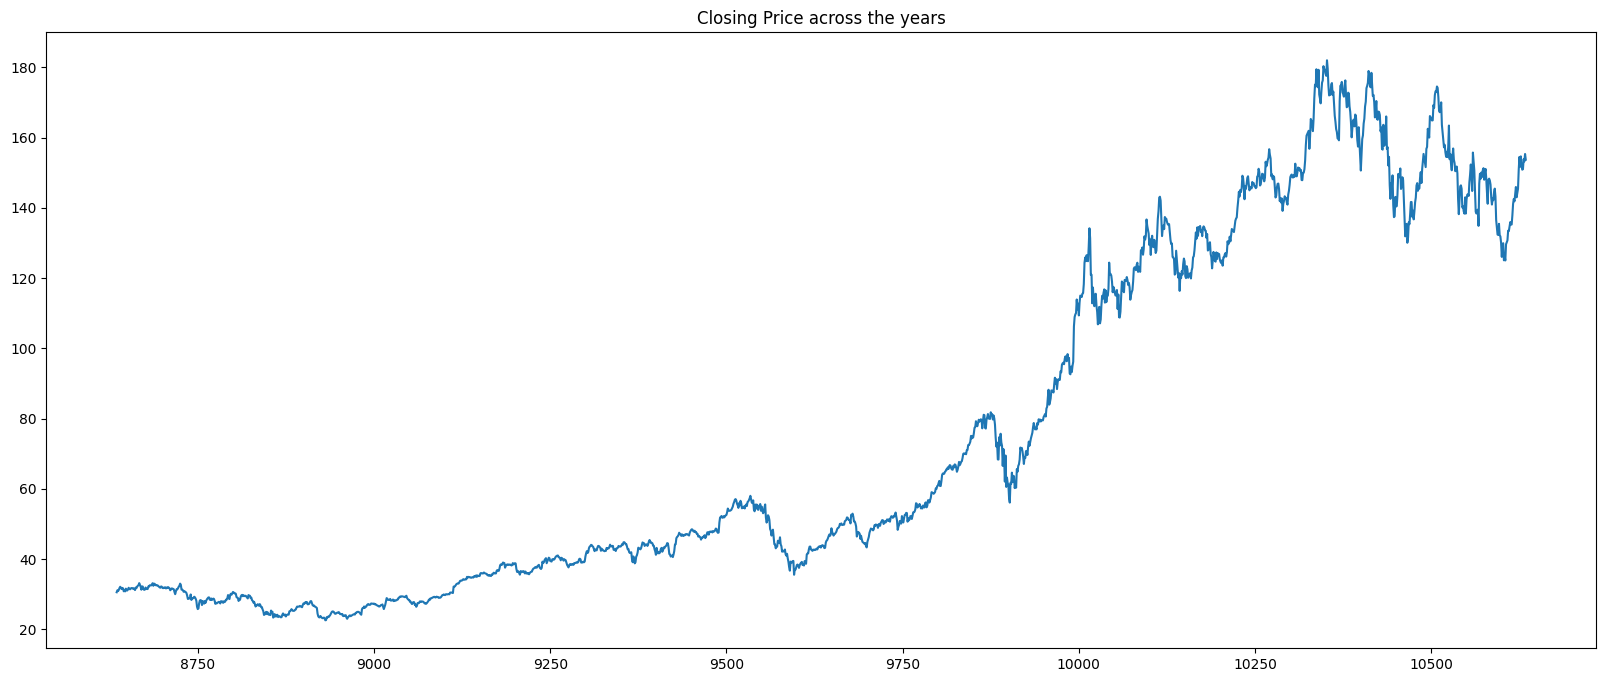

In [ ]:
#Plotting Data
plt.figure(figsize=[20,8])
plt.title('Closing Price across the years')
plt.plot(df.index,df.Close, '-', label='By Hours')

In [ ]:
#Changing Date datatype to Date
df['Date'] = pd.to_datetime(df['Date']) 
df.Date.head()

8635   2015-03-11
8636   2015-03-12
8637   2015-03-13
8638   2015-03-16
8639   2015-03-17
Name: Date, dtype: datetime64[ns]

In [ ]:
# Keeping Date as Index
df['Date'] = df['Date'].dt.tz_localize(None)
df = df.groupby([pd.Grouper(key='Date', freq='M')]).mean().reset_index()
df = df.set_index('Date')
df['Close'].fillna(method='ffill', inplace=True)

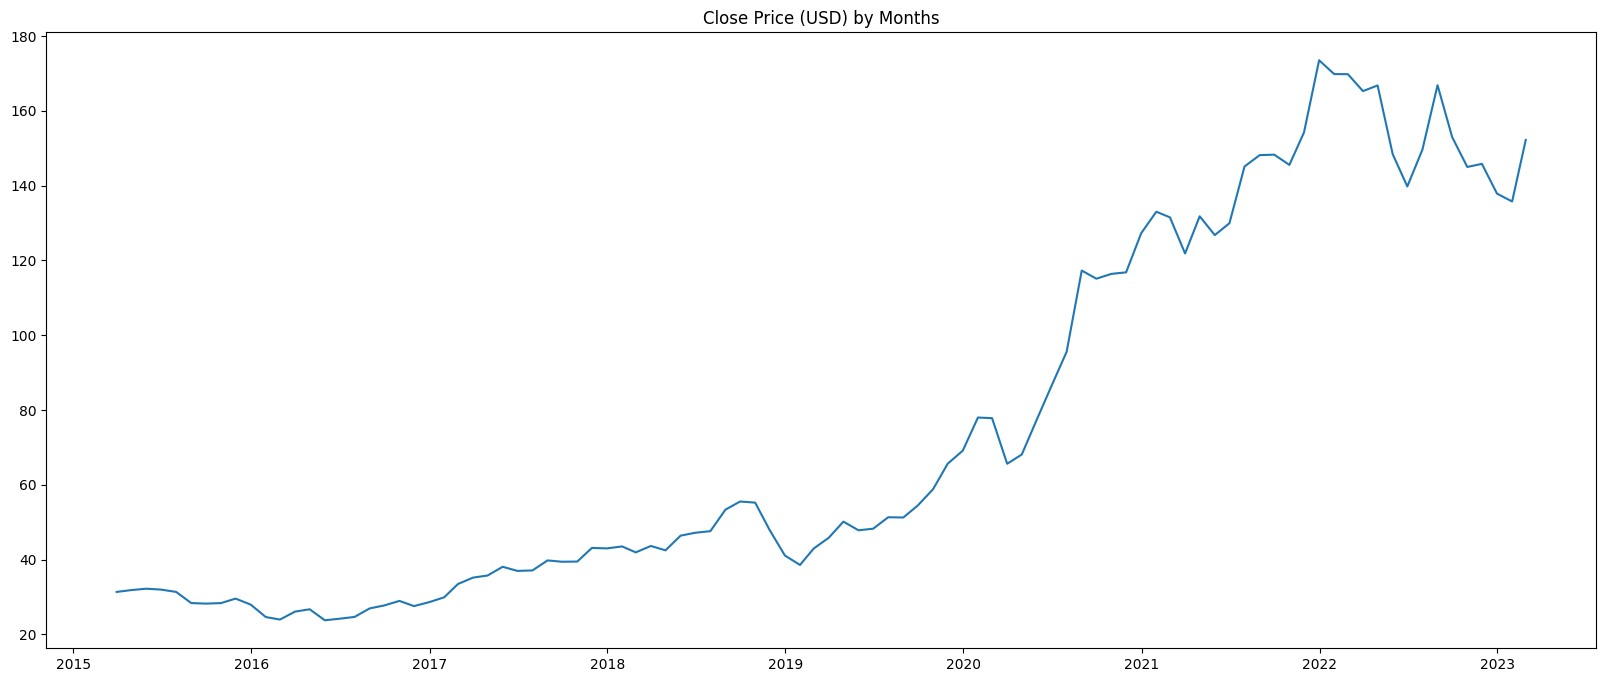

In [ ]:
# Plotting By Monhts
plt.figure(figsize=[20,8])
plt.title('Close Price (USD) by Months')
plt.plot(df.Close, '-', label='By Months')

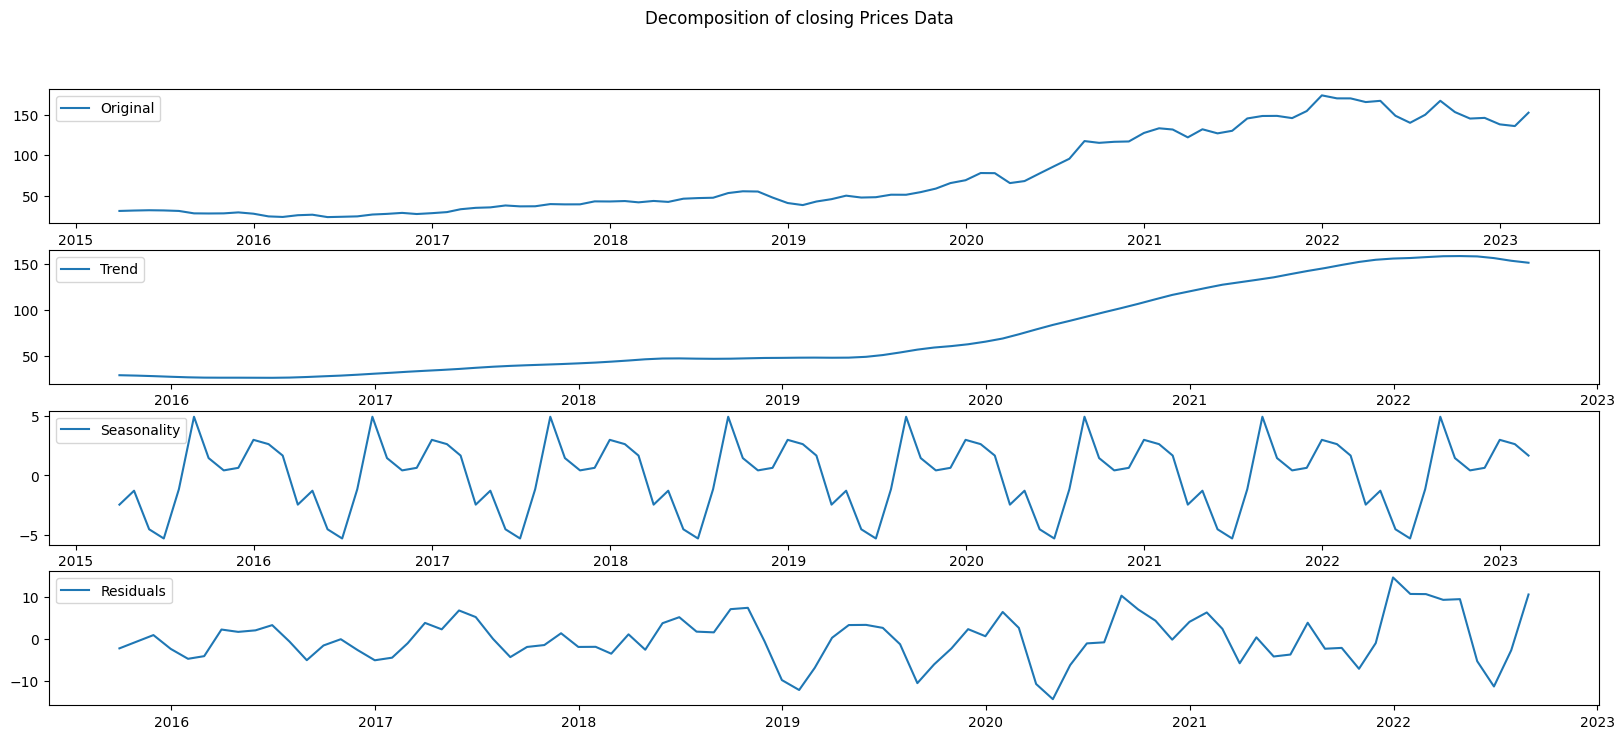

In [ ]:
# Checking for Seasonality, Trend
decomposition = sm.tsa.seasonal_decompose(df.Close)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig = plt.figure(figsize=(20,8))

plt.subplot(411)
plt.plot(df.Close, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

fig.suptitle('Decomposition of closing Prices Data')
plt.show()

In [ ]:
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df.Close)[1])

Dickey–Fuller test: p=0.946303


## **SARIMA**

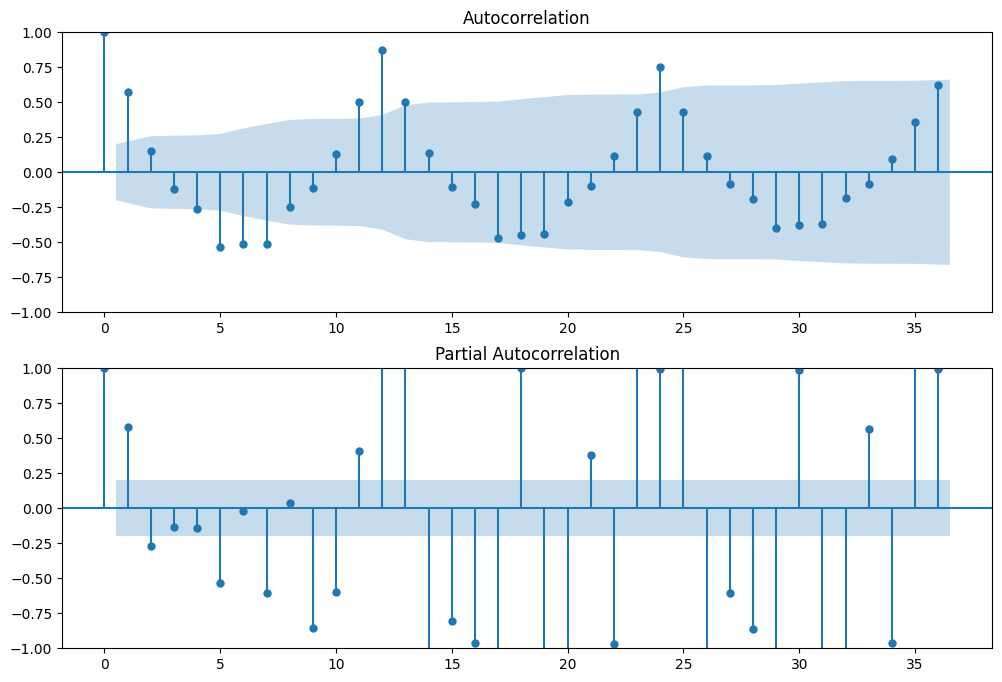

In [ ]:
#SARIMA
# Plot seasonal ACF and PACF
from statsmodels.tsa.seasonal import seasonal_decompose
# Decompose the time series into its seasonal and trend components
result = seasonal_decompose(df['Close'], model='multiplicative', period=12)
# Plot the seasonal ACF and PACF of the seasonal component
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(result.seasonal, lags=36, ax=ax1)
plot_pacf(result.seasonal, lags=36, ax=ax2)
plt.show()

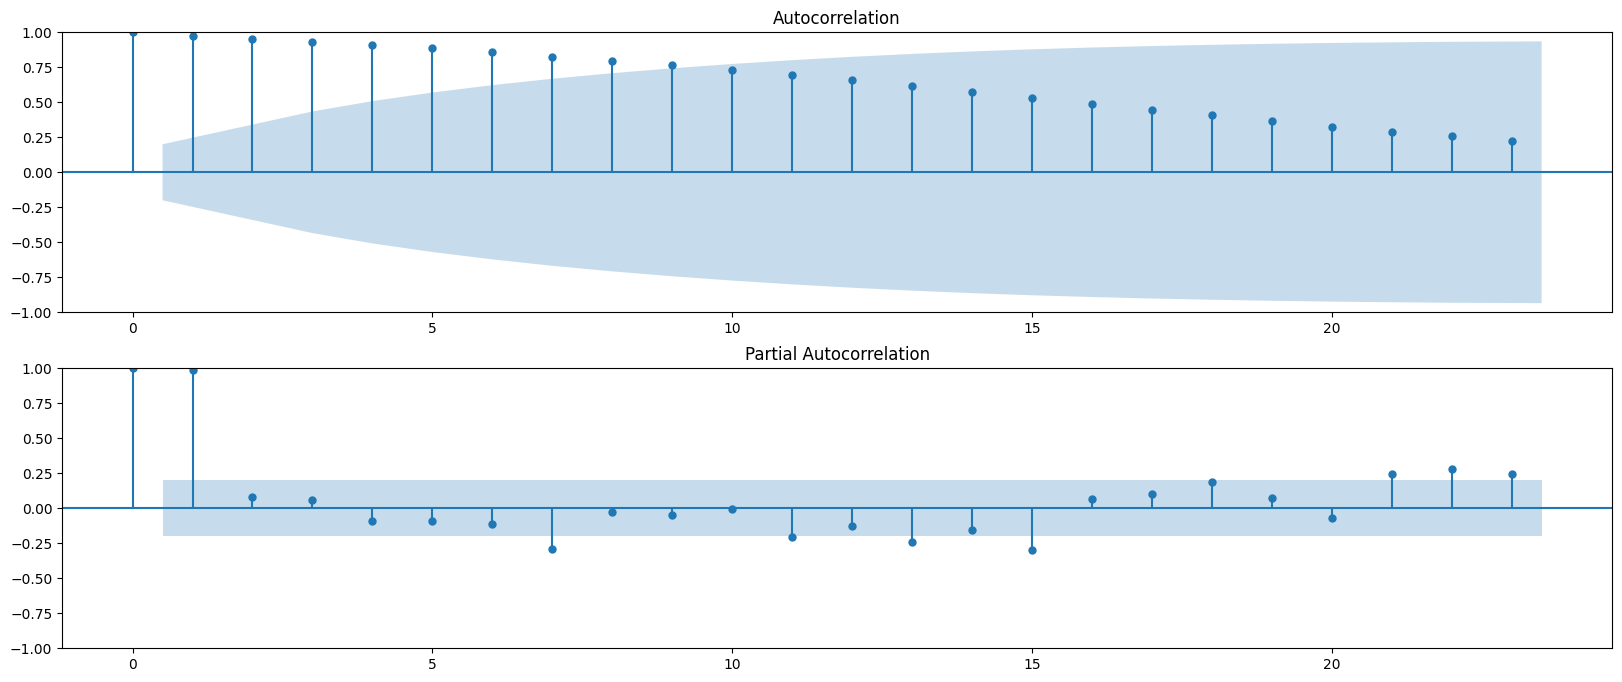

In [ ]:
# p,q values for ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
pyplot.figure(figsize=(20,8))
pyplot.subplot(211)
plot_acf(df.Close, ax=pyplot.gca(),lags=23)
pyplot.subplot(212)
plot_pacf(df.Close, ax=pyplot.gca(), lags=23)
pyplot.show()

In [ ]:
train_data  = df[0:72]
test_data =df[72:]
#training_data = train_data['Close'].values
#test_data = test_data['Close'].value

In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# calculating d
from pmdarima.arima.utils import ndiffs
ndiffs(df.Close, test="adf")

1

In [ ]:
df.shape

(96, 6)

In [ ]:
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 2)
Ps = range(0, 2)
ps = range(0, 2)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(df.Close[:72], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12),enforce_stationarity=False,
                                            enforce_invertibility=False).fit(disp=-1)
    except ValueError:
        #print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
for i in range(len(results)):
    print(results[i])

[(0, 0, 0, 0), 374.8147145537715]
[(0, 0, 0, 1), 296.5912752956348]
[(0, 0, 1, 0), 299.05690309985704]
[(0, 0, 1, 1), 294.90576905043446]
[(0, 1, 0, 0), 366.95575473790484]
[(0, 1, 0, 1), 288.440916296583]
[(0, 1, 1, 0), 296.0777192915282]
[(0, 1, 1, 1), 286.1139656856893]
[(1, 0, 0, 0), 372.5670638243886]
[(1, 0, 0, 1), 294.2299605675222]
[(1, 0, 1, 0), 291.2758323578011]
[(1, 0, 1, 1), 291.8580608556242]
[(1, 1, 0, 0), 368.701421265735]
[(1, 1, 0, 1), 290.2306646970913]
[(1, 1, 1, 0), 292.7349585331741]
[(1, 1, 1, 1), 287.9553625759715]


In [ ]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary()) 

      parameters         aic
7   (0, 1, 1, 1)  286.113966
15  (1, 1, 1, 1)  287.955363
5   (0, 1, 0, 1)  288.440916
13  (1, 1, 0, 1)  290.230665
10  (1, 0, 1, 0)  291.275832
                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                   72
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -139.057
Date:                            Tue, 18 Apr 2023   AIC                            286.114
Time:                                    00:47:51   BIC                            293.341
Sample:                                03-31-2015   HQIC                           288.808
                                     - 02-28-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------

Dickey–Fuller test:: p=0.000000


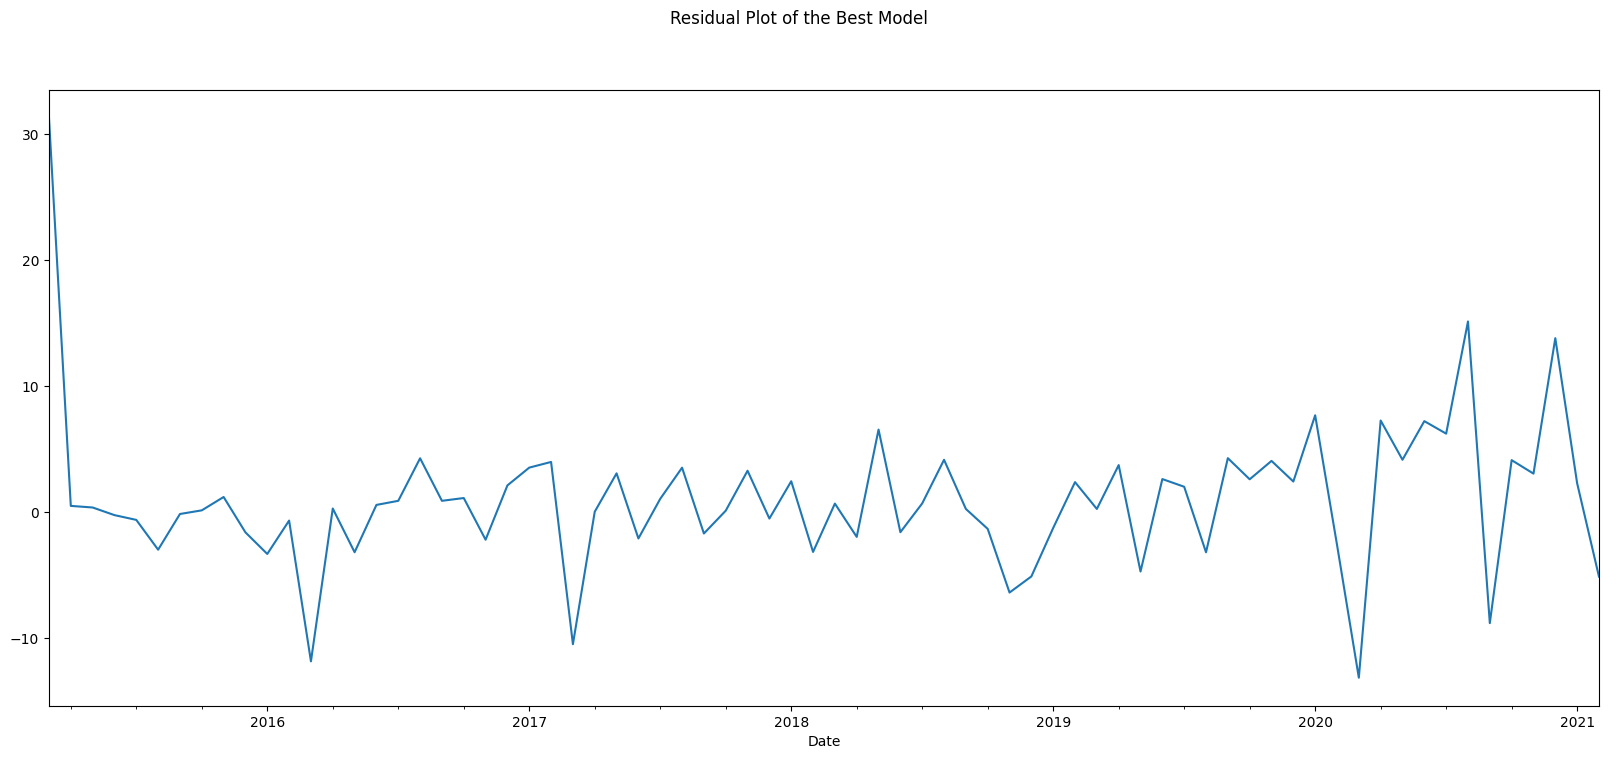

In [ ]:
#After modeling checking p-value and plotting
fig = plt.figure(figsize=(20,8))
best_model.resid.plot()
fig.suptitle('Residual Plot of the Best Model')
print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid)[1])

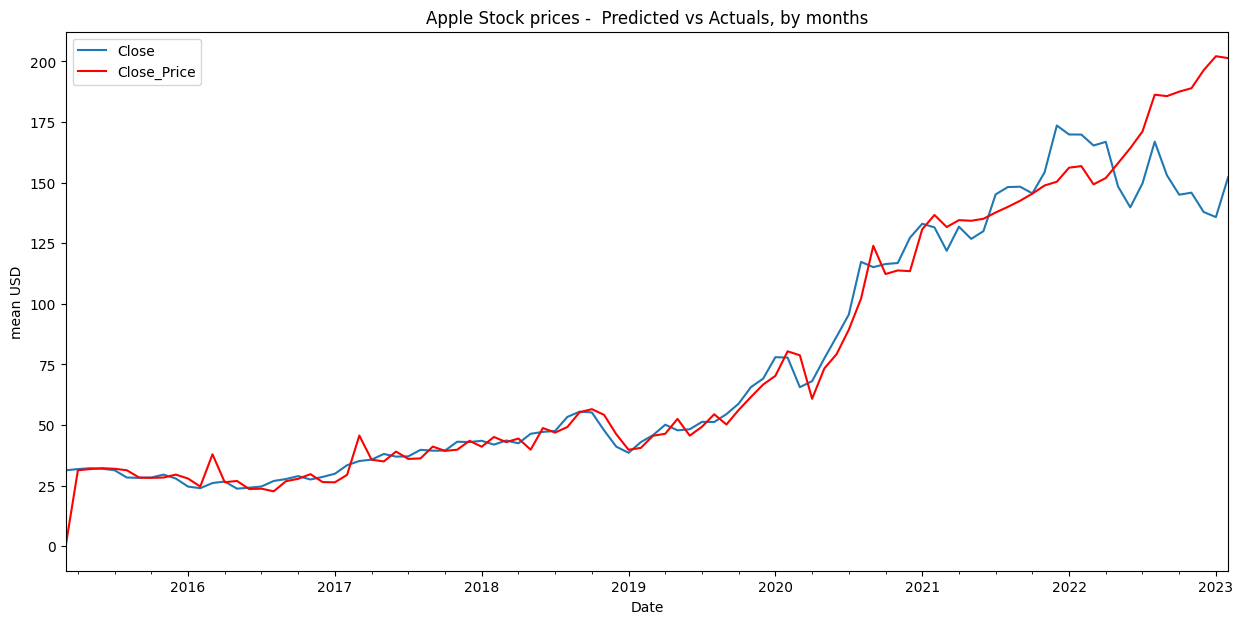

In [ ]:
#Plotting Actual vs Predicted
df_month2 = df[['Close']]
future = pd.DataFrame()
df_month2 = pd.concat([df_month2, future])
df_month2['forecast'] = best_model.predict(start=0, end=200)
plt.figure(figsize=(15,7))
df_month2.Close.plot()
df_month2.forecast.plot(color='r', label='Close_Price')
plt.legend()
plt.title('Apple Stock prices -  Predicted vs Actuals, by months')
plt.ylabel('mean USD')
plt.show()

In [ ]:
# MAE, MSE
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(df['Close'], df_month2['forecast'])
mse = mean_squared_error(df['Close'], df_month2['forecast'])
print("MAE:", mae)
print("MSE:",mse)

MAE: 8.048105695398496
MSE: 216.98396539359553


# **XGBoost**

In [ ]:
df1.shape

(10635, 7)

In [ ]:
df1['Date'] = pd.to_datetime(df1['Date']) 
df1.Date.head()
df1 = df1.set_index('Date')

In [ ]:
# Train, Test Split
X_train  = df1.iloc[8589:10102]
y_train =df1.iloc[8589:10102,3]
X_test = df1.iloc[10102:]
y_test =df1.iloc[10102:,3]

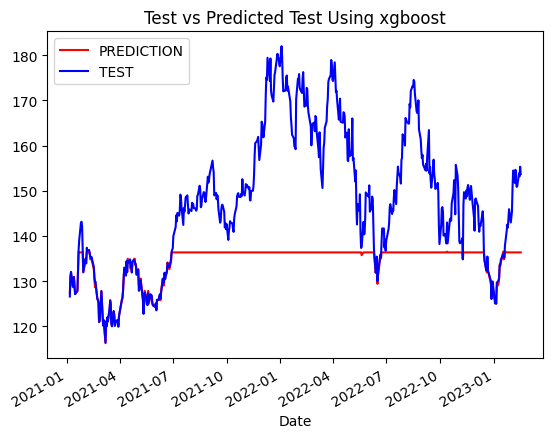

In [ ]:
# Plotting Actual vs Predicted
from xgboost import XGBRegressor

xgb = XGBRegressor(n_estimators=167, learning_rate=0.07,max_depth = 7,subsample = 1)
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)
pd.Series(y_pred, index=X_test.index).plot(legend=True, label="PREDICTION", color ='r')
pd.Series(y_test, index=X_test.index).plot(legend=True, label="TEST", color = 'blue')
plt.title("Test vs Predicted Test Using xgboost")
plt.show()


In [ ]:
#calculate MSE and MAE
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse = mean_squared_error(y_true=y_test,
                   y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,
                   y_pred=y_pred)
print("Mean Absolute Error for XGBoost:", mae)
print("Mean Squared Error for XGBoost:", mse)

Mean Absolute Error for XGBoost: 13.31762276027241
Mean Squared Error for XGBoost: 338.1815580848203


# **LSTM**

In [ ]:
df2 = df1.copy()

In [ ]:
df2=df2[['Close']]

In [ ]:
df2=df2[8589:]

In [ ]:
df2.shape

(2046, 1)

In [ ]:
# Train, Test Split
data_train = df2[:1510]
data_test = df2[1510:]

In [ ]:
training_set = data_train.values
training_set = np.reshape(training_set, (len(training_set), 1))
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
training_set = sc.fit_transform(training_set)
X_train = training_set[0:len(training_set)-1]
y_train = training_set[1:len(training_set)]
X_train = np.reshape(X_train, (len(X_train), 1, 1))

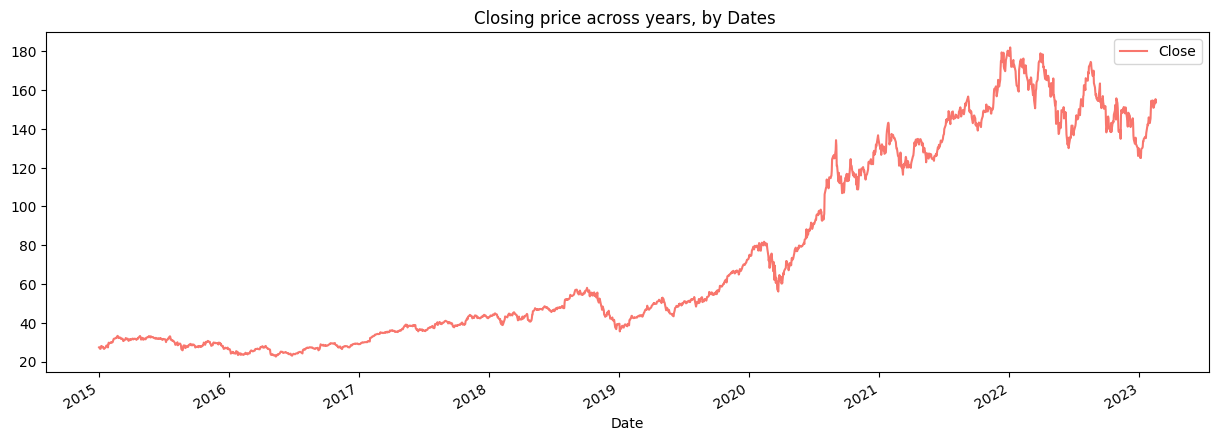

In [ ]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = df2.plot(style='', figsize=(15,5), color=color_pal[0], title='Closing price across years, by Dates ')

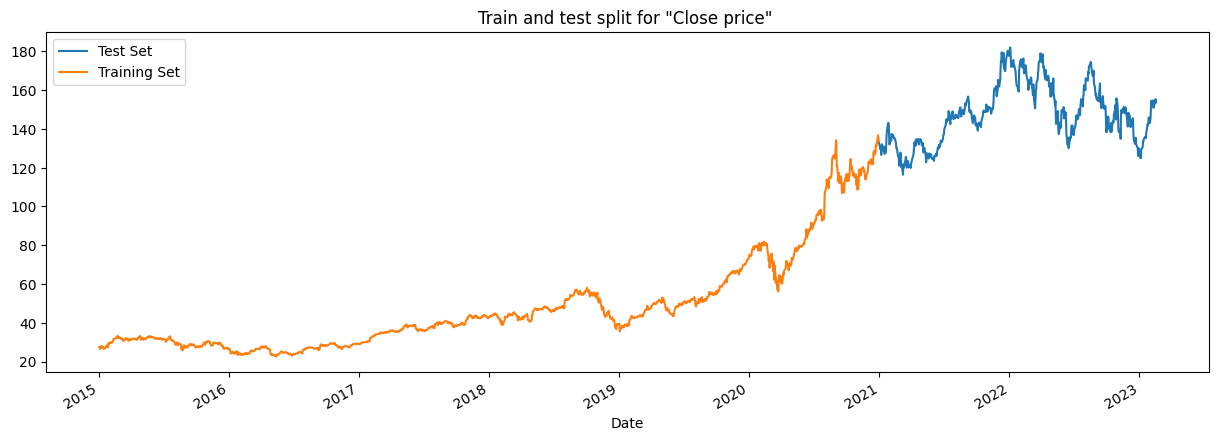

In [ ]:
_ = data_test \
    .rename(columns={'Close': 'Test Set'}) \
    .join(data_train.rename(columns={'Close': 'Training Set'}), how='outer') \
    .plot(figsize=(15,5), title='Train and test split for "Close price" ', style='')

In [ ]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation


model = Sequential()
model.add(LSTM(128,activation="sigmoid",input_shape=(1,1)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=50, verbose=2)

Epoch 1/100
31/31 - 2s - loss: 0.0861 - 2s/epoch - 63ms/step
Epoch 2/100
31/31 - 0s - loss: 0.0805 - 169ms/epoch - 5ms/step
Epoch 3/100
31/31 - 0s - loss: 0.0687 - 156ms/epoch - 5ms/step
Epoch 4/100
31/31 - 0s - loss: 0.0628 - 242ms/epoch - 8ms/step
Epoch 5/100
31/31 - 0s - loss: 0.0567 - 199ms/epoch - 6ms/step
Epoch 6/100
31/31 - 0s - loss: 0.0534 - 144ms/epoch - 5ms/step
Epoch 7/100
31/31 - 0s - loss: 0.0508 - 152ms/epoch - 5ms/step
Epoch 8/100
31/31 - 0s - loss: 0.0444 - 147ms/epoch - 5ms/step
Epoch 9/100
31/31 - 0s - loss: 0.0431 - 124ms/epoch - 4ms/step
Epoch 10/100
31/31 - 0s - loss: 0.0398 - 128ms/epoch - 4ms/step
Epoch 11/100
31/31 - 0s - loss: 0.0363 - 139ms/epoch - 4ms/step
Epoch 12/100
31/31 - 0s - loss: 0.0351 - 161ms/epoch - 5ms/step
Epoch 13/100
31/31 - 0s - loss: 0.0325 - 144ms/epoch - 5ms/step
Epoch 14/100
31/31 - 0s - loss: 0.0316 - 140ms/epoch - 5ms/step
Epoch 15/100
31/31 - 0s - loss: 0.0282 - 157ms/epoch - 5ms/step
Epoch 16/100
31/31 - 0s - loss: 0.0274 - 164ms/epoc

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 128)               66560     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Making the predictions
test_set = data_test.values
inputs = np.reshape(test_set, (len(test_set), 1))
inputs = sc.transform(inputs)
inputs = np.reshape(inputs, (len(inputs), 1, 1))
Close_price = model.predict(inputs)
Close_price = sc.inverse_transform(Close_price)

17/17 [==============================] - 1s 9ms/step


In [ ]:
data_test['Close_Prediction'] = Close_price
data_all = pd.concat([data_test, data_train], sort=False)

In [ ]:
#saving the predicted values in a common data frame for future comparision
final_data = data_all
final_data = final_data.reset_index()
final_data = final_data.rename(columns={'Close_Prediction': 'lstm'})
final_data = final_data[['Date','Close','lstm']]

Text(0.5, 1.0, 'Actual vs Prediction using LSTM')

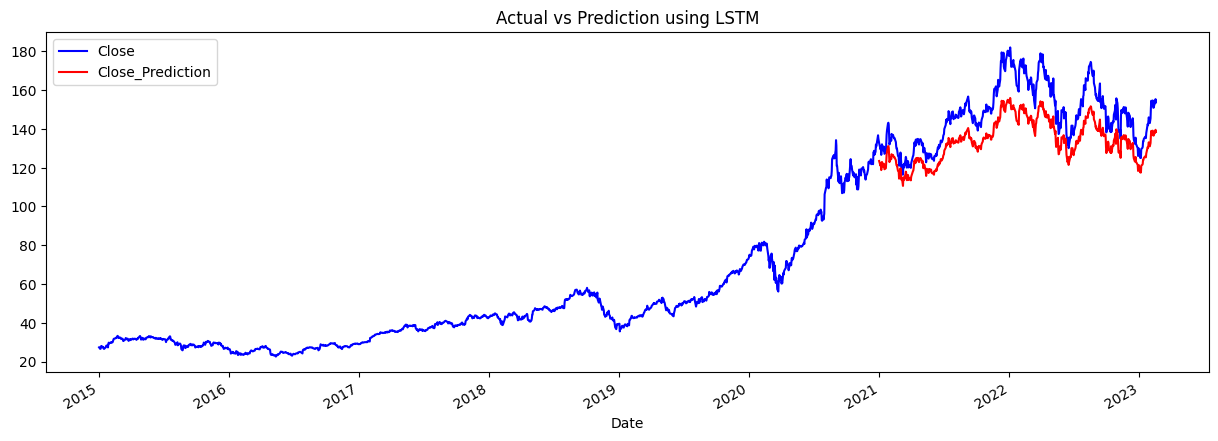

In [ ]:
# PLotting Actual vs Predicted
_ = data_all[['Close','Close_Prediction']].plot(figsize=(15, 5),color=['blue', 'red'])
plt.title('Actual vs Prediction using LSTM')

In [ ]:
#calculate MSE and MAE
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse = mean_squared_error(y_true=data_test['Close'],
                   y_pred=data_test['Close_Prediction'])
mae = mean_absolute_error(y_true=data_test['Close'],
                   y_pred=data_test['Close_Prediction'])
print("Mean Absolute Error for LSTM:", mae)
print("Mean Squared Error for LSTM:", mse)


Mean Absolute Error for LSTM: 13.775042149323511
Mean Squared Error for LSTM: 212.27822800362492
